<font size="5" color="#2874a6">Reinforcement Learning with Q-learning</font>

In [1]:
%reset -f

## Environment

## Configuration Data Classes

In [2]:
from dataclasses import dataclass, field
from typing import Dict, List, Tuple

@dataclass
class TerrainCosts:
    """Kosten für verschiedene Terrain-Typen"""
    free: float
    river: float
    swamp: float
    mountain: float
    
    def to_dict(self) -> Dict[str, float]:
        """Konvertiert zu Dictionary für Kompatibilität"""
        return {
            'free': self.free,
            'river': self.river,
            'swamp': self.swamp,
            'mountain': self.mountain
        }

@dataclass
class ObstacleConfig:
    """Konfiguration für Hindernisse im Grid"""
    river_positions: List[Tuple[int, int]]
    swamp_positions: List[Tuple[int, int]]
    mountain_positions: List[Tuple[int, int]]
    
    def to_dict(self) -> Dict[str, List[Tuple[int, int]]]:
        """Konvertiert zu Dictionary für GridEnvironment"""
        return {
            "river": self.river_positions,
            "swamp": self.swamp_positions,
            "mountain": self.mountain_positions
        }
    
    def total_count(self) -> int:
        """Gibt die Gesamtanzahl aller Hindernisse zurück"""
        return len(self.river_positions) + len(self.swamp_positions) + len(self.mountain_positions)

@dataclass
class GridConfig:
    """Konfiguration für das Grid Environment"""
    shape: Tuple[int, int]
    start_position: Tuple[int, int]
    goal_position: Tuple[int, int]
    obstacles: ObstacleConfig

@dataclass
class RewardConfig:
    """Reward-Konfiguration"""
    goal_reward: float
    terrain_costs: TerrainCosts

@dataclass
class TrainingConfig:
    """Hyperparameter für Q-Learning Training"""
    episodes: int
    alpha: float
    gamma: float
    epsilon_start: float
    epsilon_min: float
    max_steps: int
    verbose: bool

In [3]:
from typing import Literal, get_args

# Movement types
_MOVETYPES = Literal["up", "down", "left", "right"]

# Obstacle types
_OBSTACLES = Literal["river", "swamp", "mountain"]

# GridEnvironment class
class GridEnvironment:
    def __init__(self, grid_config: GridConfig):
        """
        Generisches GridEnvironment mit Data Class Konfiguration.
        
        Args:
            grid_config: GridConfig Instanz mit allen Environment-Parametern
        """
        self.shape = grid_config.shape
        self.start_position = grid_config.start_position
        self.goal_position = grid_config.goal_position
        self.obstacles = grid_config.obstacles.to_dict()
        self.state = None
        self.reset()
    
    def reset(self):
        """Setzt den State auf die Startposition zurück."""
        self.state = self.start_position
        return self.state
    
    def give_reward(self, reward_config: RewardConfig):
        """
        Berechnet den Reward für den aktuellen State.
        
        Args:
            reward_config: RewardConfig mit Terrain-Kosten und Goal-Reward
        
        Returns:
            float: Reward-Wert
        """
        # Check for goal
        if self.state == self.goal_position:
            return reward_config.goal_reward
        
        # Get terrain costs dict
        terrain_costs = reward_config.terrain_costs.to_dict()
        
        # Check for obstacles
        for obstacle_type, positions in self.obstacles.items():
            if self.state in positions:
                return terrain_costs.get(obstacle_type, terrain_costs['free'])
        
        # Free field
        return terrain_costs['free']
    
    def is_terminal(self):
        """Prüft ob der aktuelle State ein Terminal-State ist."""
        return self.state == self.goal_position
    
    def step(self, action: _MOVETYPES, reward_config: RewardConfig):
        """
        Führt eine Aktion aus und gibt den nächsten State, Reward und Done-Flag zurück.
        
        Args:
            action: Aktion ("up", "down", "left", "right")
            reward_config: RewardConfig mit Terrain-Kosten und Goal-Reward
        
        Returns:
            tuple: (next_state, reward, done)
        """
        next_state = list(self.state)
        match(action):
            case "up":
                next_state[0] = max(0, self.state[0] - 1)
            case "down":
                next_state[0] = min(self.shape[0] - 1, self.state[0] + 1)
            case "left":
                next_state[1] = max(0, self.state[1] - 1)
            case "right":
                next_state[1] = min(self.shape[1] - 1, self.state[1] + 1)
        
        self.state = tuple(next_state)
        reward = self.give_reward(reward_config)
        done = self.is_terminal()
        
        return self.state, reward, done

## Agent

The Q-learning algorithm uses the following formula to update the Q-value for a state-action-pair:

$Q(s,a) = Q(s,a) + \alpha \cdot [R + \gamma \cdot \underset{a} \max\ Q(s',a') - Q(s,a)]$

with:\
$Q(s,a)$ : Q-value for state $s$ and action $a$\
$\alpha$ : learning rate\
$R$ : immediate reward for taking action $a$ in state $s$\
$\gamma$ : discount factor, representing the importance of future rewards\
$\max Q(s',a')$ : maximum Q-value for the the next state $s'$, representing the best possible reward achievable from that state.

In [4]:
import numpy as np
import random

# Base Agent class
class Agent:
    pass

# QLearning Agent class
class QLearningAgent(Agent):
    def __init__(self, environment, actions: list):
        """
        Initialisiert den Q-Learning Agent.
        
        Args:
            environment: Das Environment in dem der Agent trainiert wird
            actions: Liste der verfügbaren Aktionen
        """
        self.environment = environment
        self.actions = list(actions)
        
        # Q-table: Speichert für jeden State und jede Aktion den erwarteten kumulativen Reward
        self.q_table = np.zeros(self.environment.shape + (len(self.actions),))
        self.epsilon = None  # Wird in fit() gesetzt

    def best_action(self, state):
        """Gibt die beste Aktion für einen State basierend auf den Q-Werten zurück."""
        return self.actions[np.argmax(self.q_table[state])]
    
    def choose_action(self, state):
        """
        Epsilon-greedy Strategie: Mit Wahrscheinlichkeit epsilon wird exploriert,
        sonst wird die beste bekannte Aktion gewählt (exploitation).
        """
        if random.uniform(0, 1) < self.epsilon:
            return self.actions[np.random.randint(len(self.actions))]  # Explore
        else:
            return self.best_action(state)  # Exploit
    
    def update_q_value(self, state, action, reward, next_state, alpha: float, gamma: float):
        """
        Aktualisiert den Q-Wert für ein State-Action-Paar mittels Bellman-Gleichung.
        Q(s,a) = Q(s,a) + α * [R + γ * max(Q(s',a')) - Q(s,a)]
        """
        action_index = self.actions.index(action)
        best_next_q = np.max(self.q_table[next_state])
        self.q_table[state][action_index] += alpha * (reward + gamma * best_next_q - self.q_table[state][action_index])

    def fit(self, training_config: TrainingConfig, reward_config: RewardConfig):
        """
        Trainiert den Agent mit Data Class Konfigurationen.
        
        Args:
            training_config: TrainingConfig mit allen Hyperparametern
            reward_config: RewardConfig mit Terrain-Kosten und Goal-Reward
        """
        # Setze epsilon
        self.epsilon = training_config.epsilon_start
        
        # Berechne epsilon_decay automatisch basierend auf Episodenanzahl
        epsilon_decay = (training_config.epsilon_min / training_config.epsilon_start) ** (1 / training_config.episodes)
        
        print(f"Automatisch berechneter Epsilon Decay: {epsilon_decay:.6f}")
        print(f"Epsilon wird von {training_config.epsilon_start} auf {training_config.epsilon_min} über {training_config.episodes} Episoden reduziert.\n")
        
        for episode in range(training_config.episodes):
            state = self.environment.reset()
            done = False
            total_reward = 0
            steps = 0

            while not done and steps < training_config.max_steps:
                action = self.choose_action(state)
                next_state, reward, done = self.environment.step(action, reward_config)
                self.update_q_value(state, action, reward, next_state, training_config.alpha, training_config.gamma)
                state = next_state
                total_reward += reward
                steps += 1

            # Epsilon Decay nach jeder Episode
            self.epsilon = max(training_config.epsilon_min, self.epsilon * epsilon_decay)

            if training_config.verbose and episode % 100 == 0: 
                print(f"Episode: {episode}, Total reward: {total_reward:.2f}, Steps: {steps}, Epsilon: {self.epsilon:.4f}")

    def path(self, reward_config: RewardConfig, start_state=None, max_steps: int = 1000):
        """
        Findet den optimalen Pfad vom Startstate zum Ziel.
        
        Args:
            reward_config: RewardConfig mit Terrain-Kosten und Goal-Reward
            start_state: Startposition (wenn None, wird environment.reset() verwendet)
            max_steps: Maximale Anzahl an Schritten (verhindert Endlosschleifen)
        
        Returns:
            tuple: (states, actions) - Listen der besuchten States und Aktionen
        """
        if start_state is None:
            state = self.environment.reset()
        else:
            state = start_state
            self.environment.state = state

        states = [state]
        actions = []
        done = False
        steps = 0
        visited_states = {state: 1}  # Zähle wie oft wir jeden State besuchen
        
        while not done and steps < max_steps:
            action = self.best_action(state)
            state, _, done = self.environment.step(action, reward_config)
            states.append(state)
            actions.append(action)
            steps += 1
            
            # Erkennung von Zyklen
            if state in visited_states:
                visited_states[state] += 1
                # Wenn wir zu oft im gleichen State sind, abbrechen
                if visited_states[state] > 3:
                    print(f"Warnung: Zyklus erkannt bei State {state}. Pfad möglicherweise nicht optimal.")
                    print(f"Der Agent ist {visited_states[state]} mal durch diesen State gegangen.")
                    break
            else:
                visited_states[state] = 1
            
            if done:
                break
        
        if steps >= max_steps:
            print(f"Warnung: Maximale Schrittanzahl ({max_steps}) erreicht. Ziel möglicherweise nicht erreichbar.")
        
        return states, actions

## Train the Agent

### Realistische 24x24 Umgebung mit Data Classes und adaptivem Epsilon Decay

Das Environment simuliert eine realistische Landschaft mit klar definierten Bewegungskosten:

**Terrain-Kosten (TerrainCosts Data Class):**
- **Freie Felder** (beige): -0.1 (Basis-Bewegungskosten)
- **Fluss** (blau): -0.5 (5x teurer als normal)
- **Moor** (braun): -0.8 (8x teurer als normal)
- **Gebirge** (grau): -1.5 (15x teurer als normal)
- **Ziel-Reward**: +10 (muss größer sein als maximale Pfadkosten)

**Optimierte Hyperparameter (TrainingConfig Data Class):**
- **Alpha (Lernrate): 0.3** - Schnelleres Lernen
- **Gamma (Discount-Faktor): 0.95** - Gute Vorausplanung für lange Pfade
- **Epsilon Start: 1.0** - Startet mit 100% Exploration
- **Epsilon Min: 0.01** - Minimum 1% Exploration bleibt erhalten

**Vorteile der Data Classes:**
- ✅ **Type Safety**: IDE kann Typen prüfen und auto-complete
- ✅ **Klare Struktur**: Alle zusammenhängenden Parameter in einer Klasse
- ✅ **Weniger Parameter**: `agent.fit(training_config, reward_config)` statt 8+ einzelne Parameter
- ✅ **Wiederverwendbar**: Config-Objekte können gespeichert/geladen werden
- ✅ **Validierung**: Einfach erweiterbar mit Validierungslogik

**Adaptive Epsilon Decay Strategie:**
Der Epsilon-Decay-Faktor wird **automatisch** basierend auf der Anzahl der Episoden berechnet! 

Formel: $\text{epsilon\_decay} = \left(\frac{\text{epsilon\_min}}{\text{epsilon\_start}}\right)^{\frac{1}{\text{episodes}}}$

In [5]:
# Flüsse - verlaufen hauptsächlich diagonal/horizontal durch die Karte
river_positions = [
    # Fluss 1 - diagonal von oben links nach unten
    (2, 5), (3, 6), (4, 7), (5, 8), (6, 9), (7, 10), (8, 11), (9, 11),
    # Fluss 2 - horizontal in der Mitte
    (12, 8), (12, 9), (12, 10), (12, 11), (12, 12), (12, 13), (12, 14), (12, 15),
    # Fluss 3 - vertikal auf der rechten Seite
    (4, 18), (5, 18), (6, 18), (7, 18), (8, 18), (9, 18), (10, 18), (11, 18),
    # Fluss 4 - zusätzlicher Fluss unten
    (20, 8), (20, 9), (20, 10), (20, 11), (21, 11), (21, 12), (21, 13),
    # Kleinere Flussarme
    (15, 5), (15, 6), (16, 6), (17, 7), (18, 7), (18, 8),
    # Weitere Flussabschnitte
    (6, 15), (7, 16), (8, 17), (9, 17),
    (14, 18), (14, 19), (15, 19), (16, 20)
]

# Moore - in feuchten Niederungen nahe Flüssen
swamp_positions = [
    # Moor-Gebiet 1 - neben Fluss 1
    (3, 5), (4, 5), (4, 6), (5, 7), (6, 8), (7, 9), (8, 10),
    (9, 10), (9, 12), (8, 12), (10, 11), (10, 12),
    # Moor-Gebiet 2 - unterhalb des horizontalen Flusses
    (13, 8), (13, 9), (13, 10), (13, 11), (13, 12), (14, 9), (14, 10), (14, 11),
    (14, 12), (14, 13), (14, 14), (15, 13), (15, 14),
    # Moor-Gebiet 3 - neben Fluss 4
    (19, 8), (19, 9), (19, 10), (19, 11), (20, 12), (20, 13), (22, 11), (22, 12),
    # Moor-Gebiet 4 - kleine Moore verstreut
    (18, 15), (19, 15), (18, 16), (20, 4), (20, 5), (21, 5),
    (5, 16), (6, 16), (7, 15), (8, 16), (9, 16),
    (15, 18), (15, 20), (16, 19), (17, 18),
    # Zusätzliche Moore
    (11, 5), (11, 6), (12, 6), (13, 5), (13, 6)
]

# Gebirge - größere zusammenhängende Gebirgsketten
mountain_positions = [
    # Gebirgskette 1 - oberer rechter Bereich (erweitert)
    (1, 20), (1, 21), (2, 19), (2, 20), (2, 21), (3, 19), (3, 20), (3, 21),
    (4, 17), (4, 19), (4, 20), (5, 17), (5, 19), (5, 20),
    # Gebirgskette 2 - linker unterer Bereich (erweitert)
    (18, 2), (18, 3), (19, 2), (19, 3), (19, 4), (20, 2), (20, 3),
    (21, 2), (21, 3), (21, 4), (22, 3), (22, 4), (22, 5), (22, 6),
    (23, 4), (23, 5), (23, 6),
    # Gebirgskette 3 - zentral, blockiert direkten Weg (erweitert)
    (9, 13), (9, 14), (10, 13), (10, 14), (10, 15), (11, 13), (11, 14), (11, 15),
    (11, 16), (12, 16), (12, 17),
    # Gebirgskette 4 - neue Barriere im oberen Bereich
    (3, 8), (3, 9), (3, 10), (4, 9), (4, 10), (4, 11),
    # Gebirgskette 5 - mittlerer Bereich
    (15, 8), (15, 9), (16, 8), (16, 9), (16, 10), (17, 10), (17, 11),
    # Einzelne Berge und Hügel
    (6, 3), (7, 3), (7, 4), (8, 4),
    (16, 19), (17, 19), (17, 20), (18, 20),
    (10, 7), (11, 7), (11, 8),
    (5, 13), (6, 13), (6, 14),
    (1, 15), (2, 15), (2, 16), (3, 16)
]

# ============================================================================
# Konfiguration mit Data Classes - ALLE Werte explizit
# ============================================================================

# Terrain-Kosten Konfiguration
terrain_costs = TerrainCosts(
    free=-0.1,
    river=-0.5,
    swamp=-0.8,
    mountain=-1.5
)

# Obstacle Konfiguration
obstacles = ObstacleConfig(
    river_positions=river_positions,
    swamp_positions=swamp_positions,
    mountain_positions=mountain_positions
)

# Grid Konfiguration
grid_config = GridConfig(
    shape=(24, 24),
    start_position=(23, 0),
    goal_position=(6, 17),
    obstacles=obstacles
)

# Reward Konfiguration
reward_config = RewardConfig(
    goal_reward=10.0,
    terrain_costs=terrain_costs
)

# Training Konfiguration
training_config = TrainingConfig(
    episodes=5000,
    alpha=0.3,
    gamma=0.95,
    epsilon_start=1.0,
    epsilon_min=0.01,
    max_steps=1000,
    verbose=True
)

# ============================================================================
# Environment und Agent erstellen
# ============================================================================

# Environment erstellen mit GridConfig
env = GridEnvironment(grid_config)

# Agent erstellen
agent = QLearningAgent(
    environment=env, 
    actions=get_args(_MOVETYPES)
)

# ============================================================================
# Training
# ============================================================================

print("Training Agent auf 24x24 Grid mit adaptivem Epsilon Decay...")
print(f"Grid: {grid_config.shape}, Start: {grid_config.start_position}, Ziel: {grid_config.goal_position}")
print(f"Anzahl Hindernisse: Flüsse={len(river_positions)}, Moore={len(swamp_positions)}, Gebirge={len(mountain_positions)}")
print(f"Gesamtzahl Hindernisse: {obstacles.total_count()} von {grid_config.shape[0]*grid_config.shape[1]} Feldern")
print("\n" + "="*60)

# Training mit Data Classes - viel sauberer!
agent.fit(training_config, reward_config)

print("="*60)
print(f"\nTraining abgeschlossen! Finales Epsilon: {agent.epsilon:.6f}")

Training Agent auf 24x24 Grid mit adaptivem Epsilon Decay...
Grid: (24, 24), Start: (23, 0), Ziel: (6, 17)
Anzahl Hindernisse: Flüsse=45, Moore=53, Gebirge=73
Gesamtzahl Hindernisse: 171 von 576 Feldern

Automatisch berechneter Epsilon Decay: 0.999079
Epsilon wird von 1.0 auf 0.01 über 5000 Episoden reduziert.

Episode: 0, Total reward: -420.20, Steps: 991, Epsilon: 0.9991
Episode: 100, Total reward: -143.70, Steps: 312, Epsilon: 0.9112
Episode: 200, Total reward: -39.10, Steps: 198, Epsilon: 0.8310
Episode: 100, Total reward: -143.70, Steps: 312, Epsilon: 0.9112
Episode: 200, Total reward: -39.10, Steps: 198, Epsilon: 0.8310
Episode: 300, Total reward: -7.80, Steps: 91, Epsilon: 0.7579
Episode: 400, Total reward: -37.30, Steps: 165, Epsilon: 0.6912
Episode: 500, Total reward: -9.80, Steps: 80, Epsilon: 0.6304
Episode: 600, Total reward: -20.60, Steps: 102, Epsilon: 0.5749
Episode: 700, Total reward: -2.70, Steps: 67, Epsilon: 0.5243
Episode: 300, Total reward: -7.80, Steps: 91, Epsilo

## Use Agent for Optimal Path

## Visualisierung des Environments

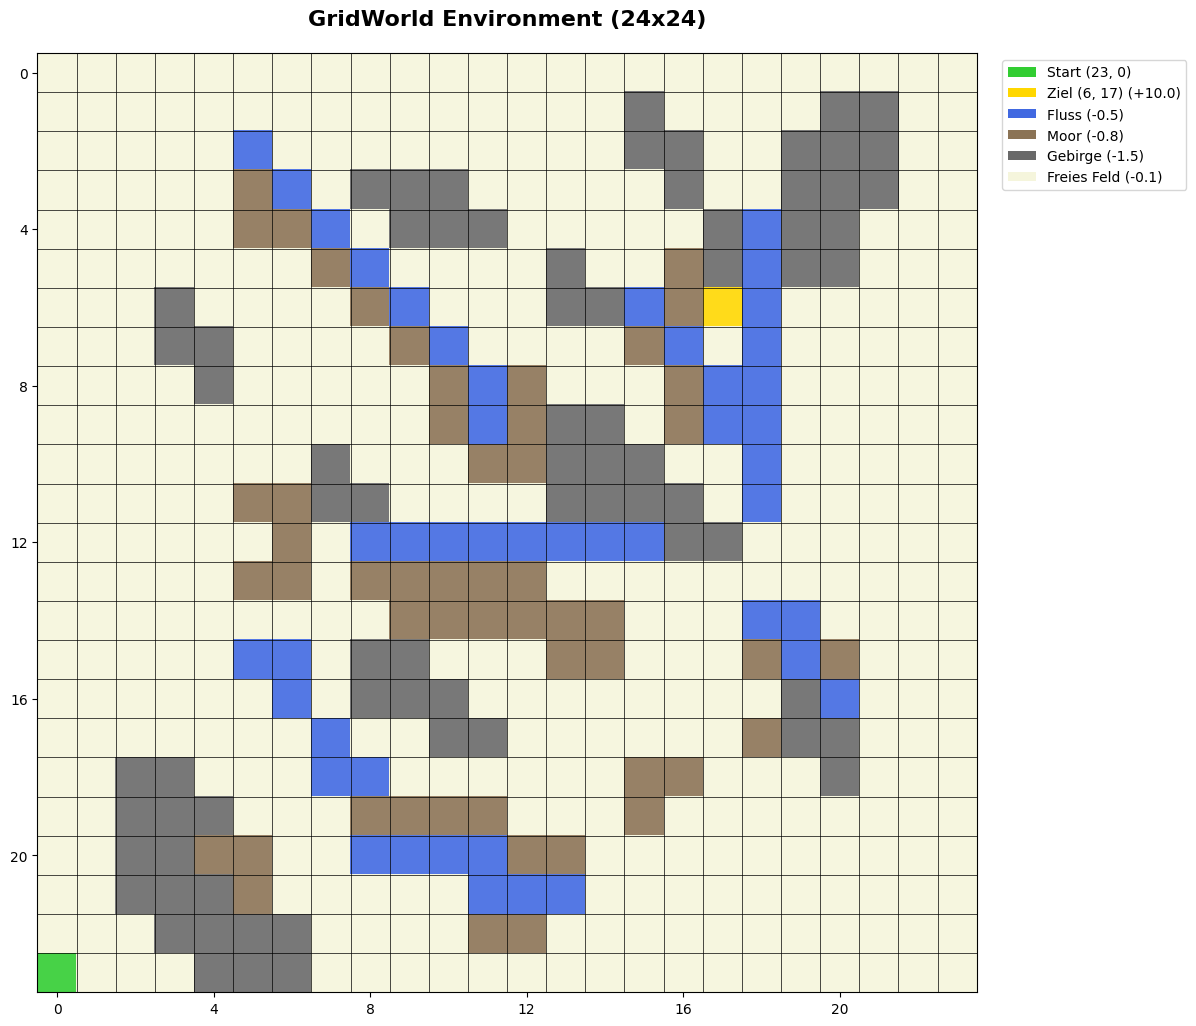

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

def visualize_environment(environment, reward_config: RewardConfig, agent=None, path_states=None):
    """
    Visualisiert das GridEnvironment mit Hindernissen und optionalem Pfad.
    
    Args:
        environment: GridEnvironment Instanz
        reward_config: RewardConfig mit Terrain-Kosten und Goal-Reward
        agent: QLearningAgent (optional) - wenn angegeben, werden Q-Werte visualisiert
        path_states: Liste von States für optimalen Pfad (optional)
    """
    # Größere Figur für 24x24 Grid
    figsize = max(12, environment.shape[0] * 0.5)
    fig, ax = plt.subplots(figsize=(figsize, figsize))
    
    # Grid-Matrix erstellen
    grid = np.zeros(environment.shape)
    
    # Hindernisse eintragen
    for obstacle_type, positions in environment.obstacles.items():
        for pos in positions:
            if obstacle_type == "river":
                grid[pos] = 1
            elif obstacle_type == "swamp":
                grid[pos] = 2
            elif obstacle_type == "mountain":
                grid[pos] = 3
    
    # Goal eintragen
    grid[environment.goal_position] = 4
    
    # Startposition
    grid[environment.start_position] = 5
    
    # Farbschema - natürliche Farben für realistische Umgebung
    colors = [
        '#F5F5DC',  # 0: Beige (freies Feld)
        '#4169E1',  # 1: Royalblau (Fluss)
        '#8B7355',  # 2: Braun (Moor)
        '#696969',  # 3: Dunkelgrau (Gebirge)
        '#FFD700',  # 4: Gold (Ziel)
        '#32CD32'   # 5: Grün (Start)
    ]
    cmap = ListedColormap(colors)
    
    # Grid visualisieren
    im = ax.imshow(grid, cmap=cmap, vmin=0, vmax=5, alpha=0.9)
    
    # Pfad visualisieren (falls vorhanden)
    if path_states:
        for i in range(len(path_states) - 1):
            y1, x1 = path_states[i]
            y2, x2 = path_states[i + 1]
            
            # Berechne Pfeilgröße basierend auf Grid-Größe
            arrow_scale = 0.3 if environment.shape[0] > 10 else 0.2
            
            ax.arrow(x1, y1, (x2 - x1) * 0.8, (y2 - y1) * 0.8, 
                    head_width=arrow_scale, head_length=arrow_scale * 0.7, 
                    fc='darkgreen', ec='darkgreen', linewidth=2.5, alpha=0.9, zorder=10)
    
    # Q-Werte als Pfeile visualisieren (nur für kleinere Grids sinnvoll)
    if agent and environment.shape[0] <= 12:
        arrow_scale = 0.15
        for i in range(environment.shape[0]):
            for j in range(environment.shape[1]):
                state = (i, j)
                q_values = agent.q_table[state]
                
                # Normalisiere Q-Werte für bessere Visualisierung
                if np.max(q_values) > 0:
                    q_norm = q_values / np.max(np.abs(q_values))
                else:
                    q_norm = q_values
                
                # Zeichne Pfeile für jede Aktion
                actions_coords = {
                    0: (0, -arrow_scale),      # up
                    1: (0, arrow_scale),       # down
                    2: (-arrow_scale, 0),      # left
                    3: (arrow_scale, 0)        # right
                }
                
                for action_idx, (dx, dy) in actions_coords.items():
                    if q_norm[action_idx] > 0.1:  # Nur signifikante Q-Werte
                        alpha = min(0.8, q_norm[action_idx])
                        ax.arrow(j, i, dx * q_norm[action_idx], dy * q_norm[action_idx],
                               head_width=0.1, head_length=0.08,
                               fc='purple', ec='purple', alpha=alpha, linewidth=1)
    
    # Grid-Linien
    ax.set_xticks(np.arange(-0.5, environment.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, environment.shape[0], 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)
    ax.tick_params(which="minor", size=0)
    
    # Achsenbeschriftung - nur jede 2. oder 4. Position für größere Grids
    tick_step = 1 if environment.shape[0] <= 10 else (2 if environment.shape[0] <= 16 else 4)
    ax.set_xticks(np.arange(0, environment.shape[1], tick_step))
    ax.set_yticks(np.arange(0, environment.shape[0], tick_step))
    ax.set_xticklabels(np.arange(0, environment.shape[1], tick_step))
    ax.set_yticklabels(np.arange(0, environment.shape[0], tick_step))
    
    # Terrain costs für Legende
    tc = reward_config.terrain_costs
    
    # Legende erstellen
    legend_elements = [
        mpatches.Patch(facecolor='#32CD32', label=f'Start {environment.start_position}'),
        mpatches.Patch(facecolor='#FFD700', label=f'Ziel {environment.goal_position} (+{reward_config.goal_reward})'),
        mpatches.Patch(facecolor='#4169E1', label=f'Fluss ({tc.river})'),
        mpatches.Patch(facecolor='#8B7355', label=f'Moor ({tc.swamp})'),
        mpatches.Patch(facecolor='#696969', label=f'Gebirge ({tc.mountain})'),
        mpatches.Patch(facecolor='#F5F5DC', label=f'Freies Feld ({tc.free})')
    ]
    
    if path_states:
        legend_elements.append(mpatches.Patch(facecolor='darkgreen', label='Optimaler Pfad'))
    
    if agent and environment.shape[0] <= 12:
        legend_elements.append(mpatches.Patch(facecolor='purple', label='Q-Werte (Pfeile)'))
    
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10)
    
    ax.set_title(f'GridWorld Environment ({environment.shape[0]}x{environment.shape[1]})', 
                 fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

# Environment visualisieren
visualize_environment(env, reward_config)

### Environment mit Q-Werten und optimalem Pfad

Optimaler Pfad von (23, 0) zum Ziel (6, 17):
Anzahl Schritte: 34
Pfad: [(23, 0), (22, 0), (21, 0), (20, 0), (19, 0), (18, 0), (18, 1), (17, 1), (16, 1), (15, 1), (14, 1), (14, 2), (13, 2), (12, 2), (11, 2), (10, 2), (9, 2), (9, 3), (9, 4), (9, 5), (8, 5), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13), (7, 14), (7, 15), (7, 16), (7, 17), (6, 17)]

Aktionen: ['up', 'up', 'up', 'up', 'up', 'right', 'up', 'up', 'up', 'up', 'right', 'up', 'up', 'up', 'up', 'up', 'right', 'right', 'right', 'up', 'up', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'up']

Gesamtkosten des Pfades: -5.60
Finale Belohnung am Ziel: +10.0
Netto-Reward: 4.40

Durchquerte Felder:
  Freie Felder: 30 (Kosten: -3.00)
  Flüsse: 2 (Kosten: -1.00)
  Moore: 2 (Kosten: -1.60)
  Gebirge: 0 (Kosten: -0.00)

Visualisierung des optimalen Pfades...


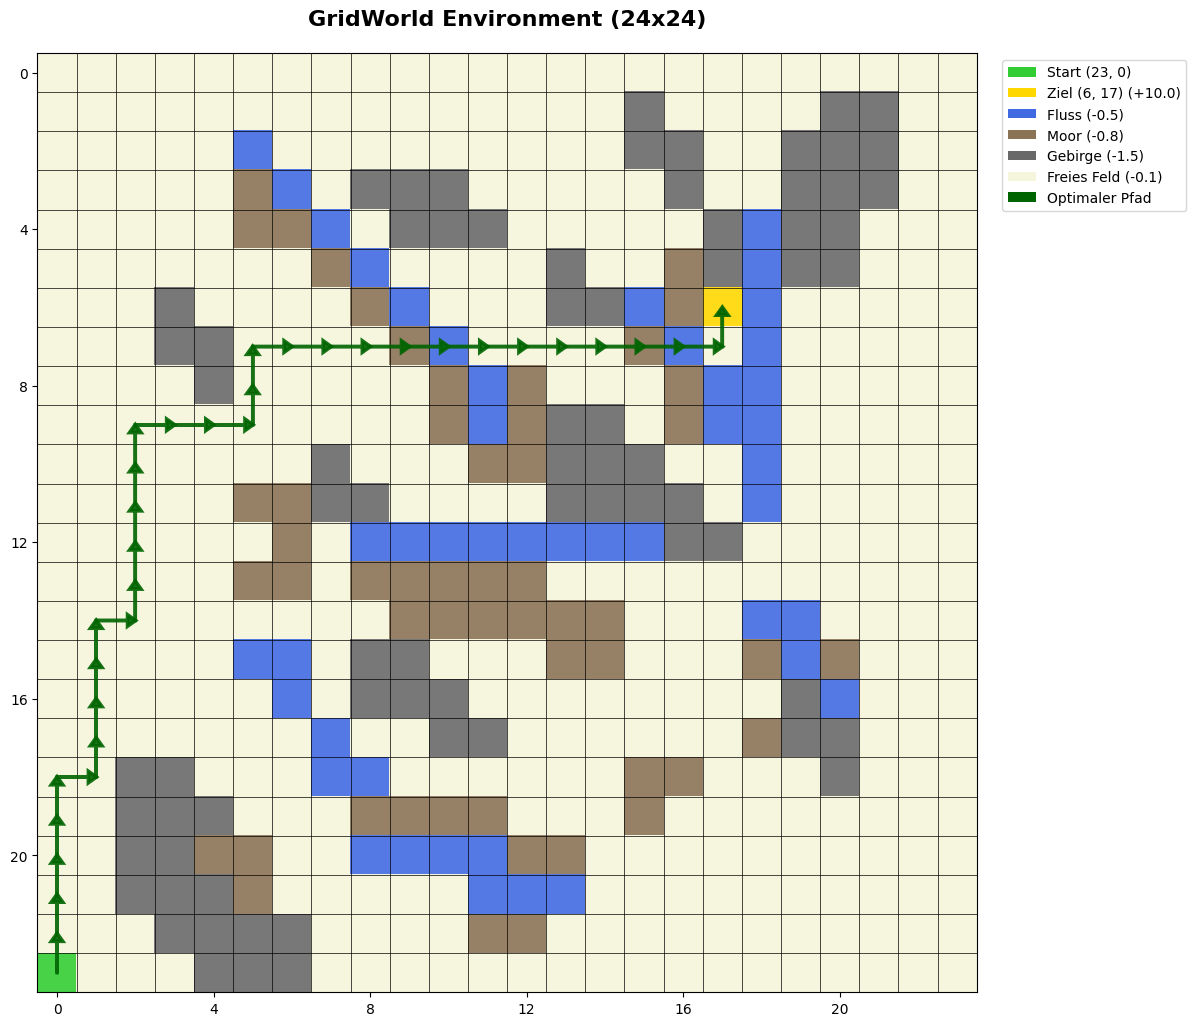

In [7]:
# Optimalen Pfad berechnen - jetzt mit RewardConfig!
states, actions = agent.path(
    reward_config=reward_config,
    start_state=grid_config.start_position,
    max_steps=1000
)

print(f"Optimaler Pfad von {grid_config.start_position} zum Ziel {grid_config.goal_position}:")
print(f"Anzahl Schritte: {len(states) - 1}")
print(f"Pfad: {states}")
print(f"\nAktionen: {actions}")

# Berechne Gesamtkosten des Pfades
total_cost = 0
for state in states[:-1]:  # Letzter State ist das Ziel
    env.state = state
    reward = env.give_reward(reward_config)
    total_cost += reward

print(f"\nGesamtkosten des Pfades: {total_cost:.2f}")
print(f"Finale Belohnung am Ziel: +{reward_config.goal_reward}")
print(f"Netto-Reward: {total_cost + reward_config.goal_reward:.2f}")

# Analysiere welche Hindernisse durchquert wurden
obstacles_crossed = {"river": 0, "swamp": 0, "mountain": 0, "free": 0}
for state in states[:-1]:
    if state in env.obstacles.get("river", []):
        obstacles_crossed["river"] += 1
    elif state in env.obstacles.get("swamp", []):
        obstacles_crossed["swamp"] += 1
    elif state in env.obstacles.get("mountain", []):
        obstacles_crossed["mountain"] += 1
    else:
        obstacles_crossed["free"] += 1

tc = reward_config.terrain_costs
print(f"\nDurchquerte Felder:")
print(f"  Freie Felder: {obstacles_crossed['free']} (Kosten: {obstacles_crossed['free'] * tc.free:.2f})")
print(f"  Flüsse: {obstacles_crossed['river']} (Kosten: {obstacles_crossed['river'] * tc.river:.2f})")
print(f"  Moore: {obstacles_crossed['swamp']} (Kosten: {obstacles_crossed['swamp'] * tc.swamp:.2f})")
print(f"  Gebirge: {obstacles_crossed['mountain']} (Kosten: {obstacles_crossed['mountain'] * tc.mountain:.2f})")

# Environment mit Agent und Pfad visualisieren
print("\n" + "="*50)
print("Visualisierung des optimalen Pfades...")
print("="*50)
visualize_environment(env, reward_config, agent=None, path_states=states)

Optimaler Pfad von (2, 10) zum Ziel (6, 17):
Anzahl Schritte: 13
Pfad: [(5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (4, 12), (4, 13), (4, 14), (4, 15), (5, 15), (6, 15), (6, 16), (6, 17)]

Aktionen: ['right', 'right', 'right', 'right', 'right', 'up', 'right', 'right', 'right', 'down', 'down', 'right', 'right']

Gesamtkosten des Pfades: -3.50
Finale Belohnung am Ziel: +10.0
Netto-Reward: 6.50

Visualisierung des Pfades von (2, 10) zum Ziel...


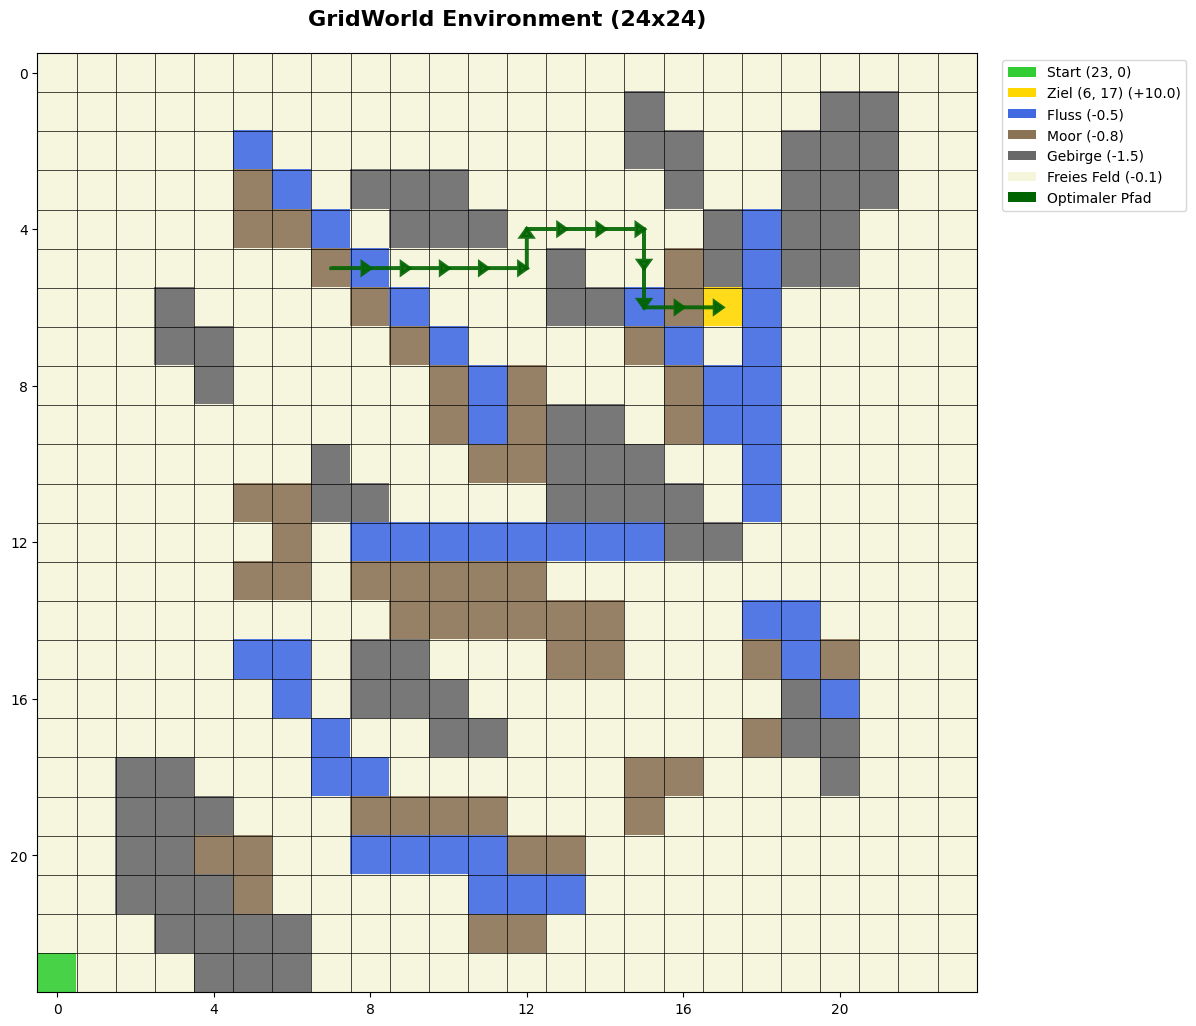

In [14]:
# Test von einem anderen Startpunkt - auch mit RewardConfig!
states, actions = agent.path(
    reward_config=reward_config,
    start_state=(np.random.randint(0,23), np.random.randint(0,23)),
    max_steps=1000
)
print(f"Optimaler Pfad von (2, 10) zum Ziel {grid_config.goal_position}:")
print(f"Anzahl Schritte: {len(states) - 1}")
print(f"Pfad: {states}")
print(f"\nAktionen: {actions}")

# Berechne Gesamtkosten des Pfades
total_cost = 0
for state in states[:-1]:  # Letzter State ist das Ziel
    env.state = state
    reward = env.give_reward(reward_config)
    total_cost += reward

print(f"\nGesamtkosten des Pfades: {total_cost:.2f}")
print(f"Finale Belohnung am Ziel: +{reward_config.goal_reward}")
print(f"Netto-Reward: {total_cost + reward_config.goal_reward:.2f}")

# Environment mit Pfad visualisieren
print("\n" + "="*50)
print("Visualisierung des Pfades von (2, 10) zum Ziel...")
print("="*50)
visualize_environment(env, reward_config, agent=None, path_states=states)